In [1]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import random

In [2]:
device = 'cuda' # cuda or cpu

In [3]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0, 0.1, 0.5, 1, 5, 10, 100, 1000]
# lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 100 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов
acc_delete = [] 
filename = 'Hypernet_lowrank_lamn50_sn3+1' # куда сохранять
lam_hidden_num = 50
start_num = 3
mode = 'lowrank'
lambda_sample_num = 5

In [4]:
# сохранение данных
def save(file):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()
    
def load(path = filename):
    infile = open(path, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file
    
    

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [6]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1))

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 
                

In [7]:
# проверка что все работает
# случай вектора
n = LowRankNet(100, 10)
n(100)- n(0)

<ipython-input-6-a758accb0f60>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-6-a758accb0f60>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)


tensor([ 1.1579e-03,  4.4358e-04, -3.1865e-04,  3.2437e-04,  9.0420e-05,
         3.2893e-04,  4.0364e-04,  8.0103e-04,  3.8385e-04, -1.4532e-04,
         9.3460e-05, -8.5342e-04, -4.9203e-04,  1.0955e-03,  2.6686e-04,
        -5.0107e-04, -6.9356e-04, -3.5524e-05,  1.4722e-04, -4.9192e-04,
         1.3196e-04,  7.8094e-04, -5.0154e-04,  3.7491e-04, -7.2670e-04,
        -4.2802e-04, -2.1482e-04, -6.1572e-05,  7.6455e-04, -8.5819e-04,
        -5.1409e-04, -3.8001e-04, -2.3258e-04, -5.6469e-04, -4.0627e-04,
        -3.2903e-04,  1.0856e-03, -8.3484e-04, -9.5175e-04,  6.8972e-04,
         1.2773e-04, -1.1337e-03,  3.4571e-04,  6.0070e-04,  5.2279e-04,
        -3.9132e-04, -1.2994e-04, -1.7625e-04,  7.2122e-06, -2.2772e-04,
        -2.9835e-04, -1.7881e-07,  6.0558e-04,  4.9710e-05,  6.5863e-04,
         7.4020e-04,  2.1636e-04,  2.3735e-04,  4.2582e-04,  1.0834e-03,
        -4.0892e-04, -7.6619e-04, -2.2078e-04,  4.9284e-04, -5.7805e-04,
         9.3067e-04,  1.1504e-04,  5.8293e-04, -4.3

In [8]:
# проверка что все работает
# случай матрицы
n = LowRankNet((100, 20), 10)
n(100) - n(0)

<ipython-input-6-a758accb0f60>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-6-a758accb0f60>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-6-a758accb0f60>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-6-a758accb0f60>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)


tensor([[-6.1625e-04,  4.0583e-04, -6.5077e-05,  ...,  3.8743e-07,
          3.6196e-04,  3.4638e-04],
        [ 6.1025e-04, -4.2704e-04, -5.9105e-05,  ..., -2.4839e-04,
         -5.2603e-04, -4.3452e-05],
        [-5.3713e-04,  3.5816e-04, -3.5007e-05,  ...,  4.3936e-05,
          3.4495e-04,  2.4928e-04],
        ...,
        [-6.3423e-04,  4.0828e-04, -1.1307e-04,  ..., -9.2089e-05,
          3.1003e-04,  4.6821e-04],
        [ 6.0985e-04, -4.0704e-04,  3.7774e-05,  ..., -5.3838e-05,
         -3.9433e-04, -2.7824e-04],
        [ 8.3520e-04, -5.5788e-04,  4.9610e-05,  ..., -7.7993e-05,
         -5.4292e-04, -3.7590e-04]], device='cuda:0', grad_fn=<SubBackward0>)

In [10]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

In [11]:
l = VarLayerLinearAppr(784, 10)

<ipython-input-6-a758accb0f60>:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-6-a758accb0f60>:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  gain_const2)


In [12]:
l.log_sigma_b(100)

tensor([-2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999,
        -2.9999, -2.9999], device='cuda:0', grad_fn=<AddBackward0>)

In [13]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    


In [14]:
def train_batches(net, loss_fn, optimizer, i, out, out_loss, kld, loss, epoch, lam):
    for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad() 
            loss[i] = 0 
            for _ in range(lambda_sample_num):
                if (mode == 'frank'):
                    lam_param = None
                else:
                    lam = np.random.uniform(0, 100)
                    lam_param = lam/100
                out[i] = net(x, lam_param)
                # правдоподобие должно суммироваться по всей обучающей выборке
                # в случае батчей - она приводится к тому же порядку 
                out_loss[i] = loss_fn(out[i], y)* len(train_data) 
                kld[i] =  net.KLD(lam_param) *lam
                loss[i] += (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data, lam)            

            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()

In [15]:
def statistic(net, loss_fn, i, kld, loss, out, out_loss):
    net.eval()  
    kld[i] =  net.KLD(1) 
    loss[i] = kld[i]
    for x,y in test_loader:
         if device == 'cuda':
            x = x.cuda()
            y = y.cuda()          
    out[i] = net(x, 1)   
    out_loss[i] = loss_fn(out[i], y)* len(train_data)
    #  print(out_loss[i])
    # print(loss[i])
    loss[i] += out_loss[i]
    net.train()
    print (loss[i])
    return loss[i]


    

In [16]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
def init_nets(loss_fn_nets):
    for i in range(start_num):
        if mode == 'lowrank':
            nets.append(VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)))
        elif mode == 'linear':
            nets.append(VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)))
        else:
            raise ValueError('Bad mode')
        optimizer_nets.append(optim.SGD(nets[i].parameters(), lr=0.001))
        loss_fn_nets.append(nn.CrossEntropyLoss())
    loss_graph=[[],[],[]]
    out = [None, None, None]
    out_loss = [None, None, None]
    kld = [None, None, None]
    loss = [None, None, None]
    return out, out_loss, kld, loss, loss_graph

def train_nets(out, out_loss, kld, loss, loss_graph,l_frank):
    for epoch in range(epoch_num):             
        for i,net in enumerate(nets):
            train_batches(net,loss_fn_nets[i], optimizer_nets[i],i, out, out_loss, kld, loss, epoch, l_frank)
        print ('end of epoch: ', epoch)   
        for i,net in enumerate(nets):
            print("Number of net:",i)        
            #loss_graph[i].append(statistic(net, loss_fn_nets[i], i, kld, loss, out, out_loss))

        

In [17]:
#print(loss_graf)
def graph_loss_func(loss_graph, nets):
    for i,net in enumerate(nets): 
        plt.plot(loss_graph[i])
    plt.ylabel('Loss function')
    plt.xlabel('Number of epoche')
    plt.show()
#print(out_loss)

#graph_loss_func()

In [18]:
def test_acc(out): # точность классификации
    acc = []
    for i,net in enumerate(nets):
        correct = 0
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        acc.append(correct / len(test_data))
    print(sum(acc)/len(acc))   
    return(acc)
#test_acc(out)

In [19]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту

def init_coeff(prune_coef, mu, sigma):
    for i,net in enumerate(nets): 
        mu.append(net[0].mean) 
        sigma.append(t.exp(2*net[0].log_sigma))
        prune_coef.append((mu[i]**2/sigma[i]).cpu().detach().numpy())  


In [20]:
# будем удалять по 10% от модели и смотреть качество
def delete_10(acc_delete, prune_coef, mu, sigma, nets, out):
    acc_delete = []
    sorted_coefs = []
    for i, net in enumerate(nets):
        sorted_coefs.append(np.sort(prune_coef[i].flatten()))
    for j in range(10):
        for i,net in enumerate(nets): 
            ids = (prune_coef[i] <= sorted_coefs[i][round(j/10*len(sorted_coefs[i]))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(out))
    return acc_delete    


In [21]:
def graph(acc_delete, lamb):
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 12, 12
    plt.rcParams.update({'font.size': 27})
    plt.rc('lines', linewidth=4)
    for k, lam in enumerate(lamb):
        acc_delete_n = np.array(acc_delete[k])
        plt.plot(proc, np.mean(acc_delete_n, 1), label = 'lambda = {}'.format(str(lam)))
        # откладываем ошибку вокруг среднего, альфа - прозрачность линии
        plt.fill_between(proc, np.mean(acc_delete_n, 1)  + np.std(acc_delete_n, 1) , np.mean(acc_delete_n, 1) - np.std(acc_delete_n, 1) , alpha = 0.5 )
    plt.ylabel('Точность классификации', fontsize = 27)
    plt.xlabel('Процент удаления', fontsize = 27)
    plt.tick_params(axis='both', which='major', labelsize=27)
    plt.legend(loc='lower left')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig('Hypernet_lowrank3 + 1')
    plt.show()

acc_delete = load('lowrank3 + 1')    
graph(acc_delete, lamb)


    

FileNotFoundError: [Errno 2] No such file or directory: 'lowrank3 + 1'

In [22]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
def delete_last10():
    flag = 0
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round((0.9+j/100)*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        (test_acc())
    for i,net in enumerate(nets):
        net[0].mean.data*=0
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
#delete_last10()    

In [ ]:
loss_fn_nets =[]
nets = []
optimizer_nets = []
mu_glob = []
sigma_glob = []
prune_coef_glob = []
init_nets_output = init_nets(loss_fn_nets)
train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], None)
old_nets = nets[:]

for k,lam in enumerate(lamb):
    for i, net in enumerate(nets):
        new_net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
        for j in range(0, 2): # бежим по слоям
            lam_param = lam / 100
            new_net[j].mean.data*=0
            new_net[j].mean.data+=old_nets[i][j].mean(lam_param)
            new_net[j].mean_b.data*=0
            new_net[j].mean_b.data+=old_nets[i][j].mean_b(lam_param)
            new_net[j].log_sigma.data*=0
            new_net[j].log_sigma.data+=old_nets[i][j].log_sigma(lam_param)
            new_net[j].log_sigma_b.data*=0
            new_net[j].log_sigma_b.data+=old_nets[i][j].log_sigma_b(lam_param)
            
        nets[i] = new_net        
    acc_delete.append(None)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])

    
init_coeff(prune_coef_glob, mu_glob, sigma_glob)    
#graph_loss_func()
graph(acc_delete,lamb)
save(acc_delete)


<ipython-input-6-a758accb0f60>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-6-a758accb0f60>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-6-a758accb0f60>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-6-a758accb0f60>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-6-a758accb0f60>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)


Number of net: 0 tensor(1819676.3750, device='cuda:0') tensor(54641.7852, device='cuda:0') tensor(241366.7500, device='cuda:0') 65.46628434363829
Number of net: 0 tensor(1040616.3750, device='cuda:0') tensor(136487.3281, device='cuda:0') tensor(173824.6094, device='cuda:0') 98.33642775525173


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.6826666666666666
[0.6654, 0.7981, 0.5845]
Number of net: 0 tensor(2817230.5000, device='cuda:0') tensor(2817230.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4910514., device='cuda:0') tensor(4910514., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3628761.2500, device='cuda:0') tensor(3628761.2500, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3167724.5000, device='cuda:0') tensor(3167724.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(1372277.5000, device='cuda:0') tensor(1372277.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3680447.5000, device='cuda:0') tensor(3680447.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(2858876., device='cuda:0') tensor(2858876., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4523466., device='cuda:0') tensor(4523466., device='cuda:0') tensor(0., device='cuda:0'

Number of net: 2 tensor(3730679.5000, device='cuda:0') tensor(3587190., device='cuda:0') tensor(143489.5938, device='cuda:0') 0.1
Number of net: 2 tensor(2395432.5000, device='cuda:0') tensor(2251538., device='cuda:0') tensor(143894.6250, device='cuda:0') 0.1
end of epoch:  0
Number of net: 0
Number of net: 1
Number of net: 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(1.0000, device='cuda:0')
0.8627333333333332
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
0.8612333333333333
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.8552333333333332
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8480666666666666
nonzero 

Number of net: 0 tensor(4929643.5000, device='cuda:0') tensor(4492688.5000, device='cuda:0') tensor(436955., device='cuda:0') 1
Number of net: 0 tensor(1802862.5000, device='cuda:0') tensor(1371481., device='cuda:0') tensor(431381.4375, device='cuda:0') 1
Number of net: 1 tensor(48429.8320, device='cuda:0') tensor(33935.1602, device='cuda:0') tensor(14494.6719, device='cuda:0') 1
Number of net: 1 tensor(70718., device='cuda:0') tensor(57840.2500, device='cuda:0') tensor(12877.7490, device='cuda:0') 1
Number of net: 1 tensor(68001.3828, device='cuda:0') tensor(56524.2656, device='cuda:0') tensor(11477.1182, device='cuda:0') 1
Number of net: 1 tensor(77948.3984, device='cuda:0') tensor(67655.6172, device='cuda:0') tensor(10292.7842, device='cuda:0') 1
Number of net: 1 tensor(43803.4258, device='cuda:0') tensor(34488.4258, device='cuda:0') tensor(9315., device='cuda:0') 1
Number of net: 1 tensor(38602.5586, device='cuda:0') tensor(30154.6172, device='cuda:0') tensor(8447.9404, device='cud

0.8589000000000001
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8529
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.8436333333333333
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.8316333333333333
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.8234
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
0.7920333333333334
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
0.7256666666666667
nonzero p

Number of net: 1 tensor(351260.7188, device='cuda:0') tensor(35938.7539, device='cuda:0') tensor(315321.9688, device='cuda:0') 100
Number of net: 1 tensor(303706.3125, device='cuda:0') tensor(40601.8945, device='cuda:0') tensor(263104.4062, device='cuda:0') 100
Number of net: 1 tensor(249872.9375, device='cuda:0') tensor(29583.9258, device='cuda:0') tensor(220289.0156, device='cuda:0') 100
Number of net: 2 tensor(1.2496e+08, device='cuda:0') tensor(1086763.8750, device='cuda:0') tensor(1.2388e+08, device='cuda:0') 100
Number of net: 2 tensor(1.1818e+08, device='cuda:0') tensor(1973408.2500, device='cuda:0') tensor(1.1620e+08, device='cuda:0') 100
Number of net: 2 tensor(1.1278e+08, device='cuda:0') tensor(1810933.2500, device='cuda:0') tensor(1.1097e+08, device='cuda:0') 100
Number of net: 2 tensor(1.0883e+08, device='cuda:0') tensor(2152604.2500, device='cuda:0') tensor(1.0667e+08, device='cuda:0') 100
Number of net: 2 tensor(1.0400e+08, device='cuda:0') tensor(808227.5625, device='cu

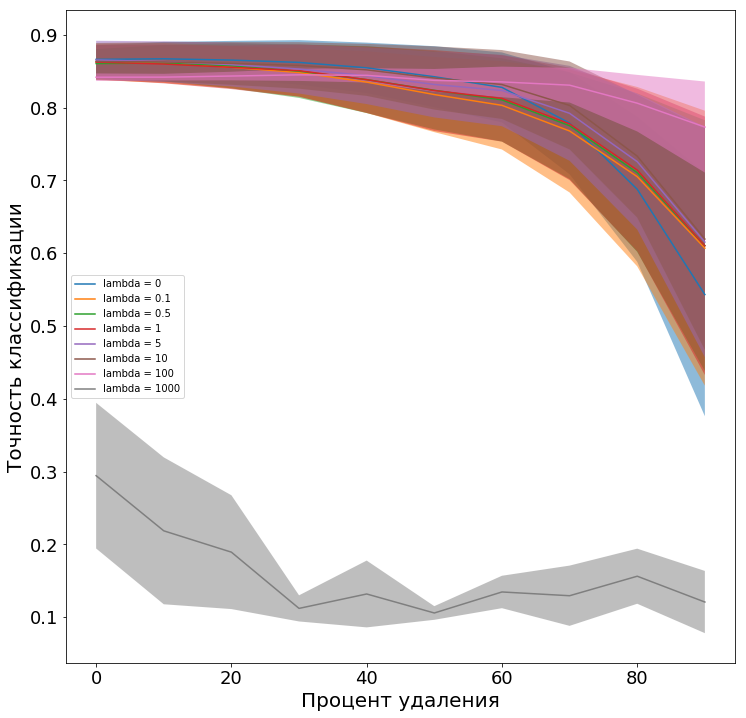

In [50]:
filename = 'lowrank3 + 1'
mode = 'frank'
lambda_sample_num = 1
epoch_num = 1
acc_delete = []

for k,lam in enumerate(lamb):
    nets = []
    optimizer_nets = []
    for i in range(len(old_nets)):
        new_net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
        for j in range(0, 2): # бежим по слоям
            lam_param = lam / 100
            new_net[j].mean.data*=0
            new_net[j].mean.data+=old_nets[i][j].mean(lam_param)
            new_net[j].mean_b.data*=0
            new_net[j].mean_b.data+=old_nets[i][j].mean_b(lam_param)
            new_net[j].log_sigma.data*=0
            new_net[j].log_sigma.data+=old_nets[i][j].log_sigma(lam_param)
            new_net[j].log_sigma_b.data*=0
            new_net[j].log_sigma_b.data+=old_nets[i][j].log_sigma_b(lam_param)
        nets.append(new_net)
        optimizer_nets.append(optim.Adam(nets[i].parameters(), lr=0.001)) # здесь уже можно и адама
    print(test_acc(init_nets_output[0]))
    train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], lam)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)   
    acc_delete.append(None)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])
graph(acc_delete,lamb)
save(acc_delete)

In [72]:
old_nets

[VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 )]